# FINAL PROJECT - Text Mining Course

**Group members:**
* Ziv Parchi - 204589949
* Dor Simai - 204038012



#Introduction
We worked on this project as part of the Text Mining course in the Hebrew University. In this project we were required to deal with analyzing the FED announcements in which we chose to focus on the FED Minutes.

Throughout the work on this project we used materials and example that were taught in class and also deepened our learning from online NLP materials.

The following notebook will take you through these steps:
* The research question
* Scraping the data
* Preprocessing
* EDA
* Models exploration
* Models evaluations
* Summay



Enjoy your reading.

#The Research Question 
**Do the FED Minutes documents affect the market direction?**

In order to get the maket direction we used the S&P 500 index - that usually reflects the movements in the maket.

# Importing relevant packages


In [1]:
! pip install html2text
!pip install matplotlib
!pip install yfinance

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 8.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
from datetime import date
import re
import threading
import pickle
import sys
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import requests
from bs4 import BeautifulSoup as bs
import datetime
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


import html2text
from urllib.request import urlopen
from bs4 import BeautifulSoup

import string
import yfinance as yf

import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import keras
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
import re 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Scraping
Scraping is a process of collating a collection of webpages by starting with an initial list of URLs (or links) and systematically processing each page to extract content and additional links.

In this step we used the www.federalreserve.gov website to allocate the relevant html text.

Using BeautifulSoup package, we were able to read the data from the website

In [3]:
url = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")
html_text = str(soup).split("Minutes")
header = "https://www.federalreserve.gov/monetarypolicy"

Getting the FAD Minutes' text & release dates of every FOMC meeting

In [4]:
list_of_urls = []
dates = []
for i in range(1,len(html_text)):
  ind = html_text[i].partition('| <a href="/monetarypolicy')[2].partition('">HTML</a>')[0]
  date = html_text[i].partition('> (Released')[2].partition(')\r\n')[0]
  if len(ind) > 0 :
    relevant_url = header + ind
    list_of_urls.append(relevant_url)
    dates.append(date)
dates[10] = " March 23, 2020"

Creating useful functions for parsering and cleaning the Minutes data and building the fed_df that presents each relies date and its content

In [5]:
def fed_parser(list_of_urls):
  list_of_data = []
  for x in list_of_urls:
    url = str(x)
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")
    html_text = str(soup)
    list_of_data.append(html_text)

  return list_of_data



In [6]:
list_of_data = fed_parser(list_of_urls)

text_fed = [list_of_data[i].partition('</strong><br/>\r\n')[2] for i in range(len(list_of_data))]

df_fed = pd.DataFrame({"date" : dates, "content" : text_fed})
df_fed.head(5)

,date,content
0,"February 16, 2022",The agenda for this meeting reported that advi...
1,"February 17, 2021",The agenda for this meeting reported that advi...
2,"April 07, 2021","By unanimous vote, the Committee approved a fi..."
3,"May 19, 2021",The System Open Market Account (SOMA) manager ...
4,"July 07, 2021",Participants resumed their discussion from the...


#Preprocessing

**As part of the follwoing step we did the following:**

1.Cleaned the data from the following cases:
* Uppercases
* Stopwords 
* Unicode - encoding the text to ASCII format
* Unicode - decoding the text
* Extra whitespace 
* Mentions 
* Market tickers
* URLs
* Hashtags 
* Punctuation

2.Added the target variable - the S&P index status change:
For this step we used Yahoo Finance API and as part of it, we calculated the index avarage of the week before the FOMC and of the week ahead, and checked if the index went up or down following the meeting.


Creating useful functions for the preprocess step

In [7]:

def clean_text(text):
    # Lowercasing the text
    text = text.lower()
    # Removing stopwords 
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # removing unicode - encoding the text to ASCII format
    text = text.encode(encoding="ascii", errors="ignore")
    # removing unicode - decoding the text
    text = text.decode()
    # cleaning the text to remove extra whitespace 
    text = " ".join([word for word in text.split()])
    # removing mentions 
    text = re.sub("@\S+", "", text)
    # remove market tickers
    text = re.sub("\$", "", text)
    # remove urls
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    # removing hashtags 
    text = re.sub("#", "", text)
    # remove punctuation
    punct = set(string.punctuation) 
    text = "".join([ch for ch in text if ch not in punct])
    
    return text

def convert_date_type(orig_date):
  new_date = datetime.datetime.strptime(orig_date," %B %d, %Y").strftime('%Y-%m-%d')
  return new_date


def get_avg_index_week_before(date_of_statement_relies):
  test_relies_date = datetime.datetime.strptime(date_of_statement_relies,'%Y-%m-%d')

  date_week_before = test_relies_date - datetime.timedelta(days=7)
  date_week_before = date_week_before.strftime('%Y-%m-%d')

  index_df_week_before = yf.download('SPY',date_week_before, date_of_statement_relies)
  avg_index_week_before = index_df_week_before['Close'].mean()

  return float(avg_index_week_before)


def get_avg_index_week_ahead(date_of_statement_relies):
  test_relies_date = datetime.datetime.strptime(date_of_statement_relies,'%Y-%m-%d')

  date_week__ahead = test_relies_date + datetime.timedelta(days=7)
  date_week_ahead = date_week__ahead.strftime('%Y-%m-%d')

  index_df_week_ahead = yf.download('SPY',date_of_statement_relies, date_week__ahead)
  avg_index_week_ahead = index_df_week_ahead['Close'].mean()

  return float(avg_index_week_ahead)


def get_index_day_before(date_of_statement_relies):
  test_relies_date = datetime.datetime.strptime(date_of_statement_relies,'%Y-%m-%d')

  date_week_before = test_relies_date - datetime.timedelta(days=7)
  date_week_before = date_week_before.strftime('%Y-%m-%d')

  index_df_week_before = yf.download('SPY',date_week_before, date_of_statement_relies)
  index_day_before = index_df_week_before.iloc[-1]['Close']
  return float(index_day_before)


def get_index_day_ahead(date_of_statement_relies):
  test_relies_date = datetime.datetime.strptime(date_of_statement_relies,'%Y-%m-%d')

  date_week__ahead = test_relies_date + datetime.timedelta(days=7)
  date_week_ahead = date_week__ahead.strftime('%Y-%m-%d')

  index_df_week_ahead = yf.download('SPY',date_of_statement_relies, date_week__ahead)
  index_day_ahead = index_df_week_ahead.iloc[1]['Close']

  return float(index_day_ahead)

def create_corpus(df, target):
    corpus = []
    
    for x in df[df['weekly_index_status']==target]['cleaned_content'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


def subtract(a,b):
  return a - b


Cleaning the content

In [8]:
df_fed['cleaned_content'] = df_fed['content'].apply(clean_text)
df_fed.head(5)

,date,content,cleaned_content
0,"February 16, 2022",The agenda for this meeting reported that advi...,agenda meeting reported advices election follo...
1,"February 17, 2021",The agenda for this meeting reported that advi...,agenda meeting reported advices election follo...
2,"April 07, 2021","By unanimous vote, the Committee approved a fi...",unanimous vote committee approved final rule r...
3,"May 19, 2021",The System Open Market Account (SOMA) manager ...,system open market account soma manager first ...
4,"July 07, 2021",Participants resumed their discussion from the...,participants resumed discussion april 2021 fom...


Adding the target variable - the S&P index status change:



In [9]:
df_fed['date'] = df_fed['date'].apply(convert_date_type)

df_fed.set_index(['date'], inplace=True)
df_fed = df_fed.sort_index().reset_index()

df_fed['avg_index_week_before'] = df_fed['date'].apply(get_avg_index_week_before)
df_fed['avg_index_week_ahead'] = df_fed['date'].apply(get_avg_index_week_ahead)

df_fed['weekly_index_diff']  = df_fed.apply(lambda f: subtract(f['avg_index_week_ahead'],f['avg_index_week_before']), axis=1)
df_fed['weekly_index_status'] = np.where(df_fed['weekly_index_diff']>0,1,0)
# dictionary = {"down":0,"up":1}
# df_fed['weekly_bin_status'] = df_fed['weekly_index_status'].map(dictionary)

# df_fed['index_day_before'] = df_fed['date'].apply(get_index_day_before)
# df_fed['index_day_ahead'] = df_fed['date'].apply(get_index_day_ahead)

# df_fed['daily_index_diff']  = df_fed.apply(lambda f: subtract(f['index_day_ahead'],f['index_day_before']), axis=1)
# df_fed['daily_index_status'] = np.where(df_fed['daily_index_diff']>0,1,0)
# dictionary = {"down":0,"up":1}
# df_fed['daily_bin_status'] = df_fed['daily_index_status'].map(dictionary)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df_fed.head()

,date,content,cleaned_content,avg_index_week_before,avg_index_week_ahead,weekly_index_diff,weekly_index_status
0,2017-02-22,Participants considered a revised proposal fro...,participants considered revised proposal subco...,235.305000,236.608002,1.303001,1
1,2017-04-05,The manager of the System Open Market Account ...,manager system open market account soma report...,235.675998,235.163998,-0.512000,0
2,2017-05-24,The manager of the System Open Market Account ...,manager system open market account soma report...,238.094003,241.395000,3.300997,1
3,2017-07-05,"By unanimous vote, the Committee selected Mark...",unanimous vote committee selected mark lj wrig...,242.212505,241.998001,-0.214504,0
4,2017-08-16,"By unanimous vote, the Committee selected Mark...",unanimous vote committee selected mark e van d...,245.635995,244.216000,-1.419995,0


#Dictionary

In [11]:
# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]


def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False


def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

#Sentiment analysis

Implementing the above sentiment functions on the data

In [12]:
temp = [tone_count_with_negation_check(lmdict,x) for x in df_fed.cleaned_content]
temp = pd.DataFrame(temp)

df_fed['wordcount'] = temp.iloc[:,0].values
df_fed['NPositiveWords'] = temp.iloc[:,1].values
df_fed['NNegativeWords'] = temp.iloc[:,2].values

df_fed['sentiment'] = (df_fed['NPositiveWords'] - df_fed['NNegativeWords']) / df_fed['wordcount'] * 100

df_fed['Poswords'] = temp.iloc[:,3].values
df_fed['Negwords'] = temp.iloc[:,4].values

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <a list of 11 Text major ticklabel objects>)

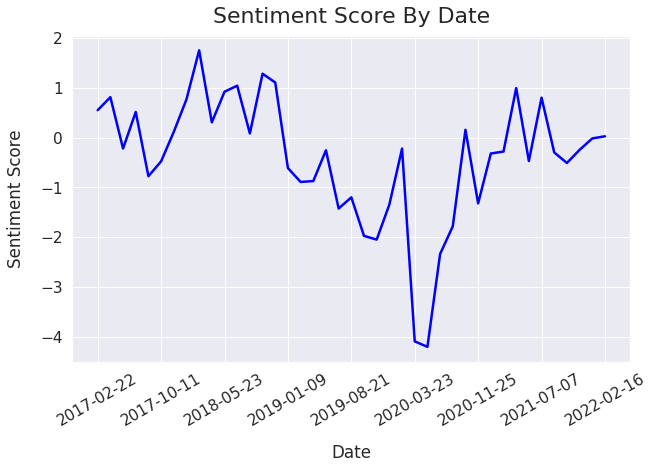

In [13]:
sns.set(font_scale=1.4)
df_fed.set_index('date')['sentiment'].plot(figsize=(10, 6), linewidth=2.5, color='blue')
plt.xlabel("Date", labelpad=15)
plt.ylabel("Sentiment Score", labelpad=15)
plt.title("Sentiment Score By Date", y=1.02, fontsize=22)
plt.xticks(rotation=30)

Positive & Negative words

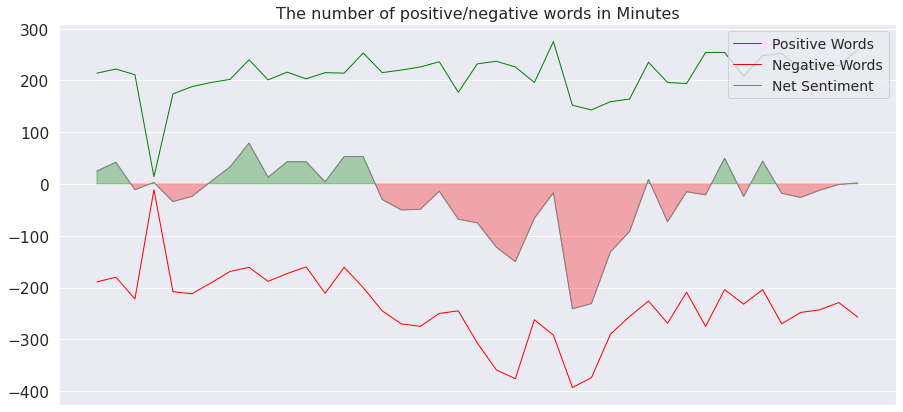

In [14]:
NetSentiment = df_fed['NPositiveWords'] - df_fed['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(df_fed.index, df_fed['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(df_fed.index, df_fed['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(df_fed.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in Minutes', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(df_fed.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(df_fed.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

ax.grid(True)

plt.show()

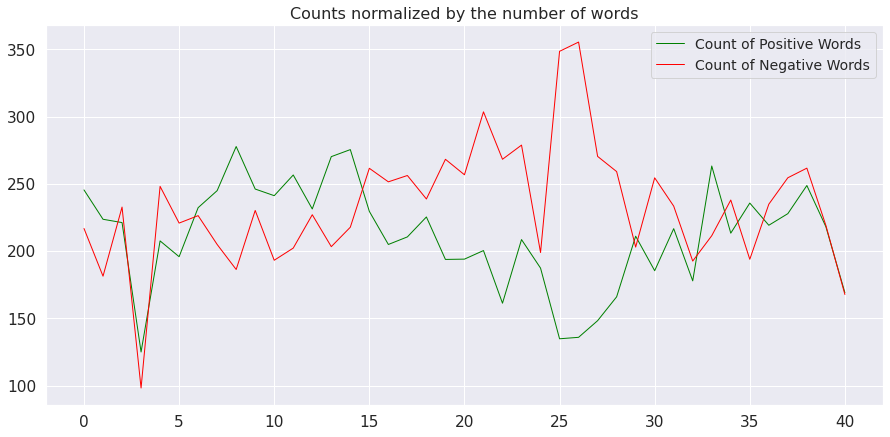

In [15]:
# Normalize data
NPositiveWordsNorm = df_fed['NPositiveWords'] / df_fed['wordcount'] * np.mean(df_fed['wordcount'])
NNegativeWordsNorm = df_fed['NNegativeWords'] / df_fed['wordcount'] * np.mean(df_fed['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df_fed.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(df_fed.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(df_fed.index[0], 'Y')
datemax = np.datetime64(df_fed.index[-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


In [16]:
# Most frequent words
corpus_lower = create_corpus(df_fed, 0)
corpus_higher = create_corpus(df_fed, 1)

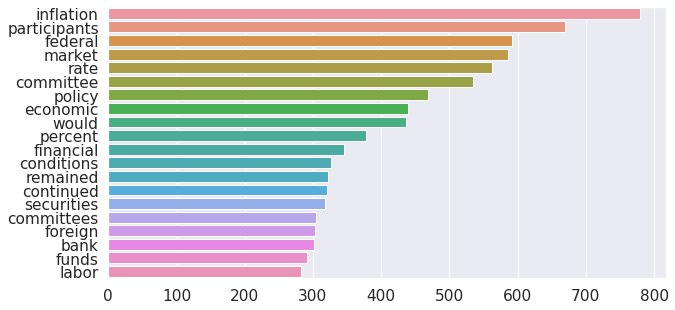

In [17]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))


# Check most frequent words which are not in stopwords
counter = Counter(corpus_lower)
most = counter.most_common()
x, y = [], []
for word, count in most[:20]:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)

**word cloud**

All words

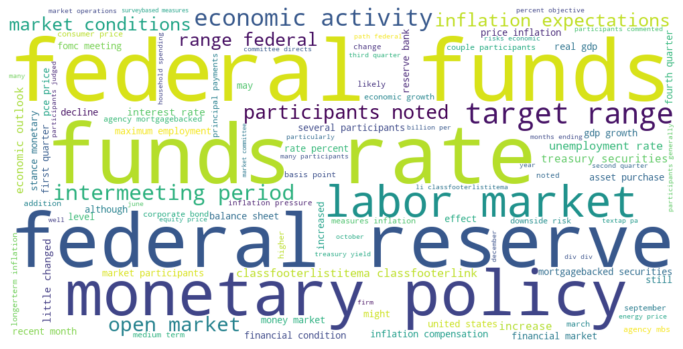

In [18]:
all_words = ""
for x in df_fed["cleaned_content"]:
  all_words += " "
  all_words += x

wordcloud = WordCloud(background_color="white", max_words=100,max_font_size=256, random_state=42, width = 1000, height = 500).generate(all_words)
wordcloud = wordcloud.generate(all_words)

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
      

Negative words

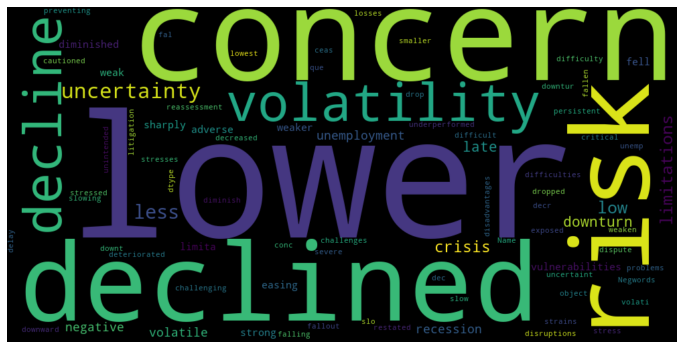

In [19]:
wordcloud = WordCloud(background_color="black", max_words=100,max_font_size=256, random_state=42, width = 1000, height = 500).generate(str(df_fed.Negwords))
wordcloud = wordcloud.generate(str(df_fed.Negwords))

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Positive words

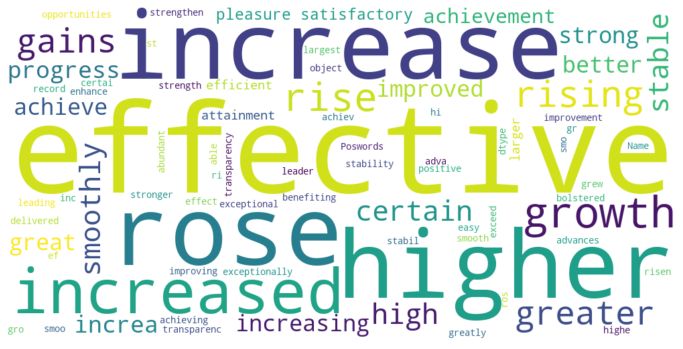

In [20]:
wordcloud = WordCloud(background_color="white", max_words=100,max_font_size=256, random_state=42, width = 1000, height = 500).generate(str(df_fed.Poswords))
wordcloud = wordcloud.generate(str(df_fed.Poswords))

fig = plt.figure(figsize=(12,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Prepering the data for the models


In [21]:
# Adding the features of the dataframe that we want to transform and/or combine. We will add also 'binstar'.
mapper = DataFrameMapper([
     ('cleaned_content', TfidfVectorizer()),
     ('weekly_index_status', None)
 ], df_out=False)

"""
Use the fit_transform method to transform the old dataframe into a new one
that can be fed to the machine learning algorithm.
"""
mapper_fit = mapper.fit(df_fed)
final_df = mapper.transform(df_fed)

print(final_df.shape)

(41, 7669)


In [22]:
df_tfidf = pd.DataFrame(final_df)
df_tfidf = df_tfidf.reset_index(drop=True) 

#Creating y and x seperately so we could normalize and split to train and test
Y = df_tfidf.iloc[:,-1]
X = df_tfidf.iloc[:,:-1]

X = preprocessing.normalize(X)
X = pd.DataFrame(X)

In [23]:
df_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,7659,7660,7661,7662,7663,7664,7665,7666,7667,7668
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.01504,...,0.0,0.008377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010979,0.009651,0.00000,...,0.0,0.007380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.008058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


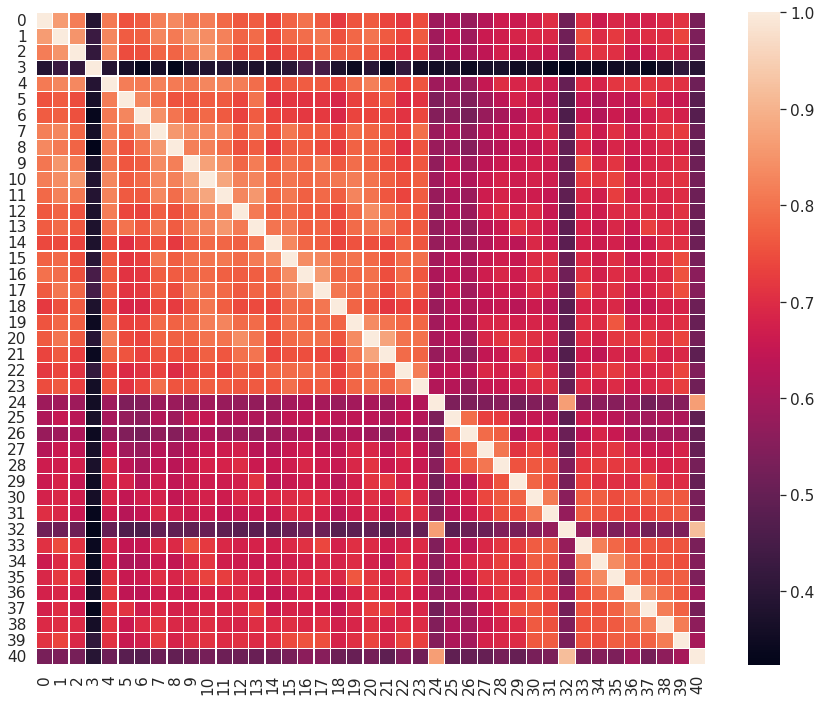

In [24]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_df = cosine_similarity(X)

fig = plt.figure(figsize=(15,12))

ax = sns.heatmap(cosine_df,linewidths=.1)

As we can see....

In [25]:
Y.value_counts()

1.0    30
0.0    11
Name: 7668, dtype: int64

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('Training set size: {0:d}\nTest set size: {1:d}'.format(len(x_train),len(x_test)))

Training set size: 32
Test set size: 9


Evaluation function for the models

In [27]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score, accuracy_score

#Creating a useful function that prints out several indicative results of a model. 
def model_results(y,y_hat):
  cm=confusion_matrix(y,y_hat)
  pre=precision_score(y,y_hat)
  rec=recall_score(y,y_hat)
  f1=f1_score(y,y_hat)
  auc=roc_auc_score(y,y_hat)
  accuracy = accuracy_score(y, y_hat)

  print(f'Precision score: {pre:3.3f}')
  print(f'Recall score: {rec:3.3f}')
  print(f'F1 score: {f1:3.3f}')
  # print(f'AUC score: {auc:3.3f}')
  print(f'Accuracy: {accuracy:3.3f}')
  print('Confusion matrix:')
  print(cm)
  return cm

#Logistic Regression

In [28]:
model_reg = LogisticRegression(random_state=0).fit(x_train, y_train)

probs = model_reg.predict_proba(x_test)
preds = probs[:,1]

log_pred = np.where(preds > preds.mean() , 1, 0) 

Precision score: 0.714
Recall score: 1.000
F1 score: 0.833
Accuracy: 0.778
Confusion matrix:
[[2 2]
 [0 5]]


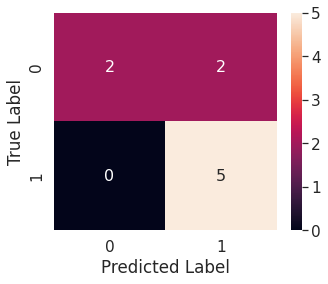

In [29]:
cm = model_results(y_test, log_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#XGBoost

Precision score: 0.625
Recall score: 1.000
F1 score: 0.769
Accuracy: 0.667
Confusion matrix:
[[1 3]
 [0 5]]


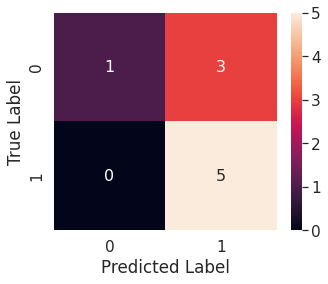

In [30]:
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier(learning_rate=0.02, n_estimators=len(x_test), objective='binary:logistic',
                    silent=True, nthread=1)
model.fit(x_train, y_train)

# make predictions for test data
y_pred_xgb = model.predict(x_test)
predictions_xgb = [round(x) for x in y_pred_xgb]

# evaluate predictions
cm = model_results(y_test, predictions_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#Decision Tree Classifier

Best Accuracy: 69.17%
Best Params: {'criterion': 'gini', 'max_depth': 1}
best estimator score is 0.78%
Precision score: 0.714
Recall score: 1.000
F1 score: 0.833
Accuracy: 0.778
Confusion matrix:
[[2 2]
 [0 5]]


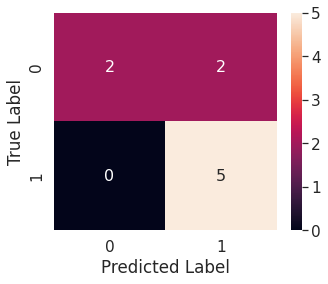

In [31]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}


gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,#default
                  cv=10,#k-fold cross validation
                  n_jobs=-1)

gs.fit(x_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

acc=np.sum(gs.best_estimator_.predict(x_test)==y_test)/y_test.shape[0]
print('best estimator score is %.2f%%'%gs.best_estimator_.score(x_test,y_test))

DT_pred = gs.predict(x_test)

cm = model_results(y_test, DT_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#Random Forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds **decision trees** on different samples and takes their majority vote for classification and average in case of regression.

Precision score: 0.625
Recall score: 1.000
F1 score: 0.769
Accuracy: 0.667
Confusion matrix:
[[1 3]
 [0 5]]


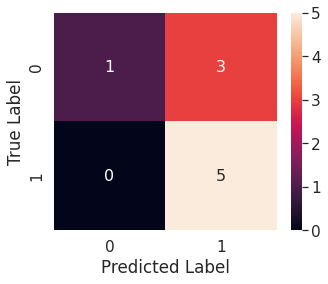

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(random_state=123,n_jobs=-1)
clf1.fit(x_train,y_train)
rf_pred = clf1.predict(x_test)

cm = model_results(y_test, rf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#KNN

A pipe is a method to pass information from one process to another process.

Grid-searching is the process of scanning the data to configure optimal parameters for a given model. Depending on the type of model utilized, certain parameters are necessary.


In [33]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_predict = knn.predict(x_test)
knn.score(x_test,y_test)

pipe=make_pipeline(StandardScaler(),
                  KNeighborsClassifier())

pipe.fit(x_train,y_train)
acc=np.sum(pipe.predict(x_test)==y_test)/y_test.shape[0]
print("The accuracy for th KNN model is:",'%.2f%%'%acc)

The accuracy for th KNN model is: 0.78%


Best Accuracy: 78.57%
Best Params: {'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 1}
Precision score: 0.625
Recall score: 1.000
F1 score: 0.769
Accuracy: 0.667
Confusion matrix:
[[1 3]
 [0 5]]


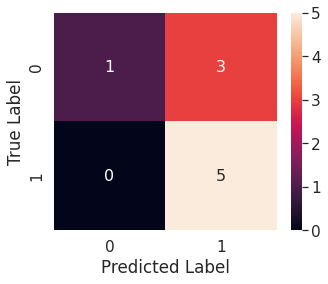

In [34]:
param_grid = {'kneighborsclassifier__p': [1,2],
              'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9]}

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  refit=True,#default
                  cv=5,#k-fold cross validation, strtified, accuracy
                  n_jobs=-1)

gs.fit(x_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))#available after fitting
print('Best Params:', gs.best_params_)#get the parameter combination

knn_pred = gs.predict(x_test)

cm = model_results(y_test, knn_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#SGDClassifier

Creating an SGDClassifier object with the logisitc regression loss. We chose parameters for learning rate (the step-size at each iteration), penalties etc.

In [35]:
SGDlogred = SGDClassifier(loss='log', penalty='l2', random_state=75 , max_iter=100, verbose=0, tol=0.001, warm_start=True)

Our classifier model needs to remember the results from the last step, hence the warm start. Some of the other values are default but we found them important so we wrote them.

Precision score: 0.714
Recall score: 1.000
F1 score: 0.833
Accuracy: 0.778
Confusion matrix:
[[2 2]
 [0 5]]


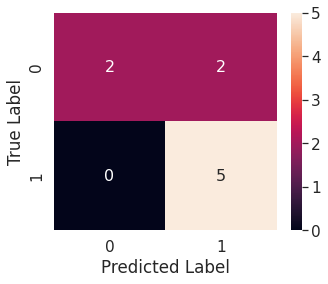

In [36]:
for i in range(5): #Number of epochs
  SGDlogred.partial_fit(x_train, y_train, classes = np.unique(y_train))

pred_sgd = SGDlogred.predict(x_test)

# evaluate predictions
cm = model_results(y_test, pred_sgd)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#Doc2Vec

Trying to fit our models to doc2vec matrix unstead of tfidf to check if they improve 

In [37]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Word2Vec, KeyedVectors
from gensim.test.utils import common_texts

# Data Pre-Processing for doc2vec Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [38]:
# Tokenization of each document:
tokenized_doc = [word_tokenize(d) for d in df_fed["cleaned_content"]]    

# Convert tokenized document into gensim formated tagged data:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]

dv_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=2, workers=12, epochs=5)

# Taking all the model's vectors into one matrix:
X_doc2vec = dv_model.docvecs.vectors_docs
X_doc2vec = preprocessing.normalize(X_doc2vec)
X_doc2vec = pd.DataFrame(X_doc2vec)

# Setting the data before building the network:
Y_doc2vec = np.array(df_fed['weekly_index_status'])

x_train_d2v, x_test_d2v, y_train_d2v, y_test_d2v = train_test_split(X_doc2vec, Y_doc2vec, test_size=0.25, random_state=42)
print('Training set size: {0:d}\nTest set size: {1:d}'.format(len(x_train),len(x_test)))

Training set size: 32
Test set size: 9


In [39]:
# Bring the data into a proper format:
train_onehot = pd.get_dummies(y_train_d2v).values
test_onehot = pd.get_dummies(y_test_d2v).values

y_train_d2v.shape, y_test_d2v.shape 

((30,), (11,))

In [40]:
# Define the model layout:
model = Sequential()
model.add(Dense(32, input_dim=100, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model:
history = model.fit(x_train_d2v, train_onehot, validation_data=None, epochs=10, verbose=2)

Epoch 1/10
1/1 - 1s - loss: 0.6771 - accuracy: 0.7667 - 696ms/epoch - 696ms/step
Epoch 2/10
1/1 - 0s - loss: 0.6735 - accuracy: 0.7667 - 8ms/epoch - 8ms/step
Epoch 3/10
1/1 - 0s - loss: 0.6700 - accuracy: 0.7667 - 10ms/epoch - 10ms/step
Epoch 4/10
1/1 - 0s - loss: 0.6666 - accuracy: 0.7667 - 8ms/epoch - 8ms/step
Epoch 5/10
1/1 - 0s - loss: 0.6631 - accuracy: 0.7667 - 16ms/epoch - 16ms/step
Epoch 6/10
1/1 - 0s - loss: 0.6593 - accuracy: 0.7667 - 6ms/epoch - 6ms/step
Epoch 7/10
1/1 - 0s - loss: 0.6554 - accuracy: 0.7667 - 5ms/epoch - 5ms/step
Epoch 8/10
1/1 - 0s - loss: 0.6516 - accuracy: 0.7667 - 5ms/epoch - 5ms/step
Epoch 9/10
1/1 - 0s - loss: 0.6480 - accuracy: 0.7667 - 5ms/epoch - 5ms/step
Epoch 10/10
1/1 - 0s - loss: 0.6445 - accuracy: 0.7667 - 5ms/epoch - 5ms/step


#LSTM 


In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_fed)
sequences = tokenizer.texts_to_sequences(df_fed)
padded_tweets = pad_sequences(sequences, maxlen=max_len)

In [42]:

from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding

embedding_layer = Embedding(5000, 64)
embedding_vector_length = 32

model = Sequential()
vocab_size = len(tokenizer.word_index) + 1 
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  

print(model.summary()) 

history = model.fit(x_train_d2v, y_train_d2v, epochs=10,batch_size=128, validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          576       
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53,877
Trainable params: 53,877
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.6965 - accuracy: 0.2333 - val_loss: 0.6921 - val_accuracy: 0.5556
Epoch 2/10
1/1 [========================

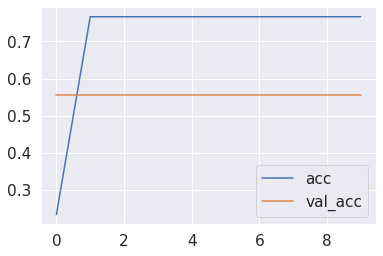

In [43]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Note that the Loss is very large and there are not enough observations for this kind of modeling. From the first epochs we get the same accuracy value and same loss. If we had many observations then this model would work nuch better (and it will probably be a very good fit for this kind of data).


Cosine similarity for Doc2Vec

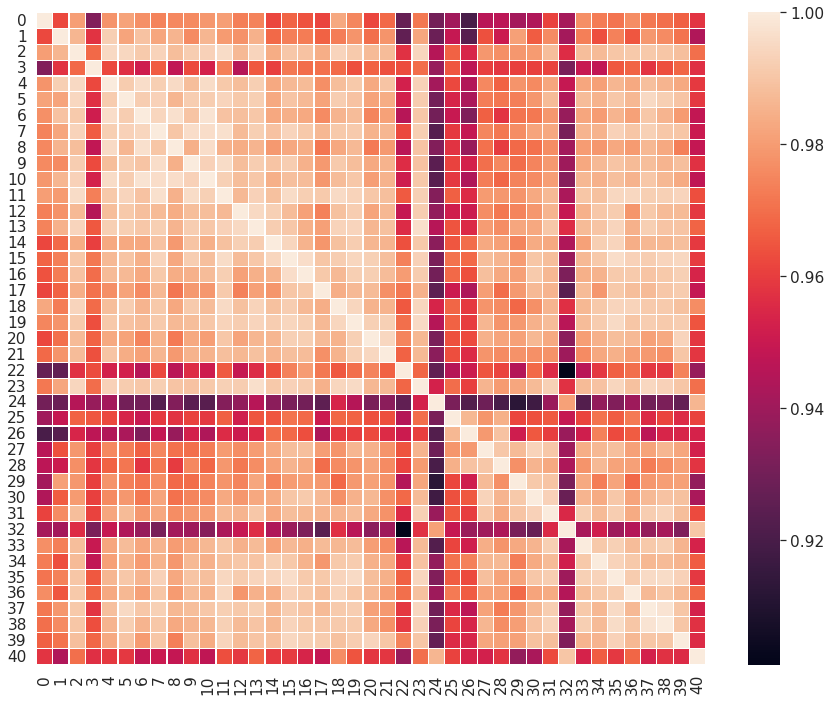

In [44]:
cosine_df = cosine_similarity(X_doc2vec)

fig = plt.figure(figsize=(15,12))

ax = sns.heatmap(cosine_df,linewidths=.1)

#Logistic Regression

Precision score: 0.857
Recall score: 0.857
F1 score: 0.857
Accuracy: 0.818
Confusion matrix:
[[3 1]
 [1 6]]


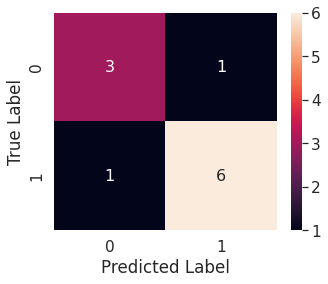

In [45]:
model_reg = LogisticRegression(random_state=0).fit(x_train_d2v, y_train_d2v)

probs = model_reg.predict_proba(x_test_d2v)
preds = probs[:,1]

log_pred = np.where(preds > preds.mean() , 1, 0) 

cm = model_results(y_test_d2v, log_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#XGBoost

Precision score: 0.750
Recall score: 0.857
F1 score: 0.800
Accuracy: 0.727
Confusion matrix:
[[2 2]
 [1 6]]


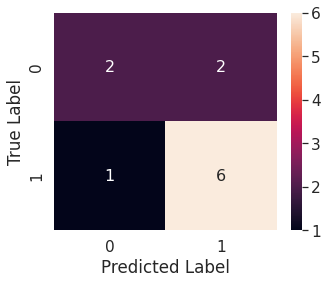

In [46]:
# fit model no training data
model = XGBClassifier(learning_rate=0.02, n_estimators=len(x_test_d2v), objective='binary:logistic',
                    silent=True, nthread=1)
model.fit(x_train_d2v, y_train_d2v)

# make predictions for test data
y_pred_xgb = model.predict(x_test_d2v)
predictions_xgb = [round(x) for x in y_pred_xgb]

# evaluate predictions
cm = model_results(y_test_d2v, predictions_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#DT

Best Accuracy: 73.33%
Best Params: {'criterion': 'gini', 'max_depth': 3}
best estimator score is 0.73%
Precision score: 0.833
Recall score: 0.714
F1 score: 0.769
Accuracy: 0.727
Confusion matrix:
[[3 1]
 [2 5]]


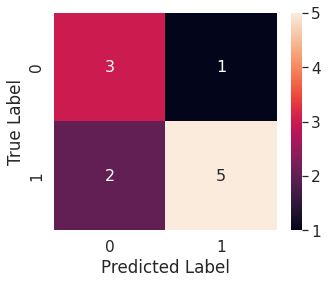

In [47]:
param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}


gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,#default
                  cv=10,#k-fold cross validation
                  n_jobs=-1)

gs.fit(x_train_d2v, y_train_d2v)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

acc=np.sum(gs.best_estimator_.predict(x_test_d2v)==y_test_d2v)/y_test_d2v.shape[0]
print('best estimator score is %.2f%%'%gs.best_estimator_.score(x_test_d2v,y_test_d2v))

DT_pred = gs.predict(x_test_d2v)

cm = model_results(y_test_d2v, DT_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#RF

Precision score: 0.667
Recall score: 0.571
F1 score: 0.615
Accuracy: 0.545
Confusion matrix:
[[2 2]
 [3 4]]


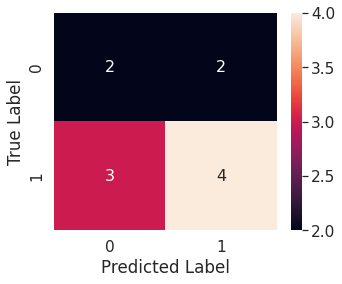

In [48]:
clf1=RandomForestClassifier(random_state=123,n_jobs=-1)
clf1.fit(x_train_d2v ,y_train_d2v)
rf_pred = clf1.predict(x_test_d2v)

cm = model_results(y_test_d2v, rf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#KNN

In [49]:
knn = KNeighborsClassifier()
knn.fit(x_train_d2v, y_train_d2v)
knn_predict = knn.predict(x_test_d2v)
knn.score(x_test_d2v,y_test_d2v)

pipe=make_pipeline(StandardScaler(),
                  KNeighborsClassifier())

pipe.fit(x_train_d2v,y_train_d2v)
acc=np.sum(pipe.predict(x_test_d2v)==y_test_d2v)/y_test_d2v.shape[0]
print("The accuracy for th KNN model is:",'%.2f%%'%acc)

The accuracy for th KNN model is: 0.73%


Best Accuracy: 76.67%
Best Params: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1}
Precision score: 0.778
Recall score: 1.000
F1 score: 0.875
Accuracy: 0.818
Confusion matrix:
[[2 2]
 [0 7]]


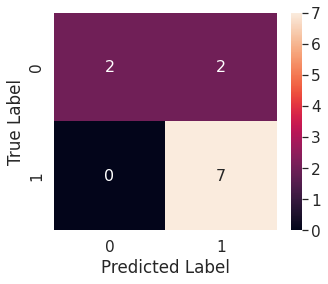

In [50]:
param_grid = {'kneighborsclassifier__p': [1,2],
              'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9]}

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  refit=True,#default
                  cv=5,#k-fold cross validation, strtified, accuracy
                  n_jobs=-1)

gs.fit(x_train_d2v, y_train_d2v)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))#available after fitting
print('Best Params:', gs.best_params_)#get the parameter combination

knn_pred = gs.predict(x_test_d2v)

cm = model_results(y_test_d2v, knn_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#SGDClassifier

In [51]:
SGDlogred = SGDClassifier(loss='log', penalty='l2', random_state=75 , max_iter=100, verbose=0, tol=0.001, warm_start=True)

Precision score: 0.636
Recall score: 1.000
F1 score: 0.778
Accuracy: 0.636
Confusion matrix:
[[0 4]
 [0 7]]


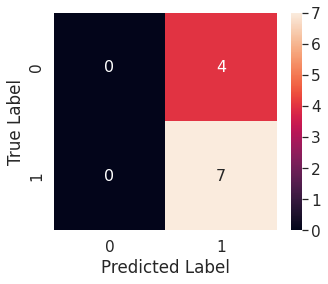

In [52]:
for i in range(15): #Number of epochs
  SGDlogred.partial_fit(x_train_d2v, y_train_d2v, classes = np.unique(y_train_d2v))

pred_sgd = SGDlogred.predict(x_test_d2v)

# evaluate predictions
cm = model_results(y_test_d2v, pred_sgd)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');